# Random Forest

Goal is to predict 5 minutes after the last timestamp for a give observation. For a given obs value, the values of y_1 and y_2 are the values for 5 minutes after the last timestamp. That is why they remain constant throughout the 'observation'. Therefore, we don't need to do any lagging of the target. The problem is that we only want 1 predicted (y_1, y_2) per observation block. It would be incorrect to just let the RF predict a (y_1, y_2) value for each row and then average across blocks, as were would be breaking the IID assumption. Instead, we have to find a way to truncate the data from an entire block into one you. While there are many ways to solve this issue, in this example we are going to start by taking the basic stats for each block. This means turning each block into a single feature vector with the mean, std, min, max values per feature, and maybe some rolling stats. In the future, we can use PCA to capture the values of these stats.

In [70]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [71]:
train_df = pd.read_csv('../train_competition_2026.csv')
train_df.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4,y_1,y_2
0,0,0,2068-09-19 23:34:11,1.38,49,7,1,3,1,0,1,105.5,95.0,67.4,36.6,23.2,33.4,107.4
1,0,0,2068-09-19 23:35:11,1.38,49,7,1,3,1,0,1,104.4,95.0,66.4,37.8,22.7,33.4,107.4
2,0,0,2068-09-19 23:36:11,1.38,49,7,1,3,1,0,1,104.0,95.0,65.2,37.0,22.1,33.4,107.4
3,0,0,2068-09-19 23:37:11,1.38,49,7,1,3,1,0,1,102.8,95.0,63.4,35.9,20.7,33.4,107.4
4,0,0,2068-09-19 23:38:11,1.38,49,7,1,3,1,0,1,101.3,95.1,59.1,34.5,18.1,33.4,107.4


In [72]:
train_df['time'] = pd.to_datetime(train_df['time'], format='%Y-%m-%d %H:%M:%S')

In [73]:
for col in train_df.columns:
    print(col, train_df[col].unique())

obs [    0     1     2 ... 17867 17868 17869]
sub_id [   0    2    3 ... 1990 1993 1995]
time <DatetimeArray>
['2068-09-19 23:34:11', '2068-09-19 23:35:11', '2068-09-19 23:36:11',
 '2068-09-19 23:37:11', '2068-09-19 23:38:11', '2068-09-19 23:39:11',
 '2068-09-19 23:40:11', '2068-09-19 23:41:11', '2068-09-19 23:42:11',
 '2068-09-19 23:43:11',
 ...
 '2127-12-11 09:04:52', '2127-12-11 09:05:52', '2127-12-11 09:06:52',
 '2127-12-11 09:07:52', '2127-12-11 09:08:52', '2127-12-11 09:09:52',
 '2127-12-11 09:34:52', '2127-12-11 09:35:52', '2127-12-11 09:36:52',
 '2127-12-11 09:37:52']
Length: 432352, dtype: datetime64[ns]
num_0 [ 1.38 -1.44 -0.19  0.06  0.44 -0.06  0.31 -0.69  0.38 -1.81  1.31 -1.19
  0.    0.12 -1.62  0.88  0.62  0.25 -0.12 -2.56  0.19 -1.06  1.25  0.5
 -0.38 -0.31  0.94  0.69 -0.81 -0.25 -0.75 -0.44 -1.25 -1.31  1.12  0.75
  1.19 -0.94 -0.5  -1.94  0.81  1.06  0.56 -1.5  -1.38  1.   -0.62 -2.12
 -1.12  1.44 -1.   -2.25 -0.56 -1.88 -2.38 -1.56 -2.94 -1.69 -2.31 -2.69
  1.5  -2

In [74]:
test_df = pd.read_csv('../test_no_outcome.csv')
test_df.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4
0,18,1,2134-04-01 22:23:14,-1.0,38,1,1,1,0,0,0,105.4,99.8,50.7,61.4,36.8
1,18,1,2134-04-01 22:24:14,-1.0,38,1,1,1,0,0,0,105.4,99.4,49.4,61.1,36.2
2,18,1,2134-04-01 22:25:14,-1.0,38,1,1,1,0,0,0,104.6,99.0,49.7,61.4,36.6
3,18,1,2134-04-01 22:26:14,-1.0,38,1,1,1,0,0,0,104.5,99.6,51.7,61.8,37.2
4,18,1,2134-04-01 22:27:14,-1.0,38,1,1,1,0,0,0,104.6,99.5,52.5,61.9,37.5


## RF using Aggregation Stats

In [75]:
def collapse_obs(df, feature_cols, aggs):
    X = (
        df
        .groupby(["obs"])[feature_cols]
        .agg(aggs)
    )
    X.columns = [
        f"{feat}_{agg}"
        for feat, agg in X.columns
    ]
    X = X.reset_index()
    return X


In [76]:
def collapse_target(df):
    y = (
        df
        .groupby(["obs"])[["y_1", "y_2"]]
        .first()
        .reset_index(drop=True)
    )
    return y

In [77]:
feature_cols = [
    c for c in train_df.columns
    if c not in ["obs", "sub_id", "time", "y_1", "y_2"]
]

aggs = ["min", "max", "mean", "std"]

X_train = collapse_obs(train_df, feature_cols, aggs).drop(columns=['obs'])
y_train = collapse_target(train_df)

X_test = collapse_obs(test_df, feature_cols, aggs)
test_index = X_test[["obs"]].copy()
X_test = X_test.drop(columns=['obs'])

In [78]:
X_train.head()

,num_0_min,num_0_max,num_0_mean,num_0_std,num_1_min,num_1_max,num_1_mean,num_1_std,num_2_min,num_2_max,...,t_2_mean,t_2_std,t_3_min,t_3_max,t_3_mean,t_3_std,t_4_min,t_4_max,t_4_mean,t_4_std
0,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,...,62.936667,8.656370,31.0,40.4,36.556667,1.990959,14.3,28.8,21.880000,3.265113
1,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,...,53.190000,4.679106,36.7,43.9,39.720000,1.888513,19.8,30.3,24.026667,2.768534
2,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,...,55.796667,4.048285,34.9,42.2,37.310000,2.041526,17.5,29.0,21.453333,3.005940
3,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,...,63.806667,4.922708,34.1,39.4,35.800000,1.079272,17.4,27.8,20.696667,1.928459
4,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,...,69.130000,3.208625,32.5,38.8,35.613333,1.162854,17.8,25.0,21.500000,1.469459


In [79]:
assert X_train.shape[0] == y_train.shape[0]
assert X_train.shape[1] == X_test.shape[1]
print(X_train.shape)

(14420, 52)


In [80]:
X_train.isna().sum()

num_0_min     0
num_0_max     0
num_0_mean    0
num_0_std     0
num_1_min     0
num_1_max     0
num_1_mean    0
num_1_std     0
num_2_min     0
num_2_max     0
num_2_mean    0
num_2_std     0
cat_0_min     0
cat_0_max     0
cat_0_mean    0
cat_0_std     0
cat_1_min     0
cat_1_max     0
cat_1_mean    0
cat_1_std     0
cat_2_min     0
cat_2_max     0
cat_2_mean    0
cat_2_std     0
cat_3_min     0
cat_3_max     0
cat_3_mean    0
cat_3_std     0
cat_4_min     0
cat_4_max     0
cat_4_mean    0
cat_4_std     0
t_0_min       0
t_0_max       0
t_0_mean      0
t_0_std       0
t_1_min       0
t_1_max       0
t_1_mean      0
t_1_std       0
t_2_min       0
t_2_max       0
t_2_mean      0
t_2_std       0
t_3_min       0
t_3_max       0
t_3_mean      0
t_3_std       0
t_4_min       0
t_4_max       0
t_4_mean      0
t_4_std       0
dtype: int64

There are some useless features here, like the binary minimums and maximums here, but RF doesn't care about multicollinearity, so we will leave them.

In [81]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Keep max_features set to None
param_grid = {
    'n_estimators': np.arange(1, 1000, 100),
    'max_features': [None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
random_search.fit(X_train_split, y_train_split)

print('Best parameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)

val_score = random_search.score(X_val, y_val)
print('Validation set score:', val_score)

Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': np.int64(601)}
Best CV score: -4.778010209102561
Validation set score: -4.6734162772703485


In [82]:
y_test_pred = random_search.predict(X_test)

pred_df = pd.concat(
    [
        test_index.reset_index(drop=True),
        pd.DataFrame(y_test_pred, columns=["y_1", "y_2"])
    ],
    axis=1
)
pred_df

,obs,y_1,y_2
0,18,40.415432,105.264155
1,19,34.750445,102.618676
2,20,35.621152,97.432590
3,21,36.010853,96.975691
4,22,38.840970,95.455563
...,...,...,...
3445,17850,56.906713,88.739400
3446,17862,55.870855,110.357139
3447,17863,52.303375,112.243852
3448,17864,45.255886,102.186081


In [83]:
# pred_df.to_csv("rf_agg_submission_1.csv", index=False)

## RF with PCA reduction

In [84]:
from sklearn.decomposition import PCA

def flatten_blocks(df, feature_cols):
    X_flat = df.groupby(["obs"])[feature_cols].apply(lambda block: block.values.flatten())
    X_flat = pd.DataFrame(X_flat.tolist(), index=X_flat.index)
    return X_flat.reset_index()


In [85]:
feature_cols = [c for c in train_df.columns if c not in ["sub_id", "obs", "time", "y_1", "y_2"]]

X_train_flat = flatten_blocks(train_df, feature_cols)
X_test_flat  = flatten_blocks(test_df, feature_cols)

In [86]:
X_train_flat.head()

,obs,0,1,2,3,4,5,6,7,8,...,380,381,382,383,384,385,386,387,388,389
0,0,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,105.5,...,1.0,3.0,1.0,0.0,1.0,94.5,93.8,59.8,34.3,17.7
1,1,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,98.6,...,1.0,3.0,1.0,0.0,1.0,95.3,92.9,52.1,38.0,22.0
2,2,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,93.1,...,1.0,3.0,1.0,0.0,1.0,91.2,93.4,52.5,36.1,19.1
3,3,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,85.1,...,1.0,3.0,1.0,0.0,1.0,87.1,95.0,61.8,36.4,20.8
4,4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,88.7,...,1.0,3.0,1.0,0.0,1.0,86.1,89.6,66.7,32.5,17.8


In [87]:
def extract_targets(df):
    return df.groupby(["obs"])[["y_1", "y_2"]].first().reset_index(drop=True)

y_train = extract_targets(train_df)

We will start with a really high k of 50, just to get a broad picture of how many components to keep.

In [88]:
k = 50

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

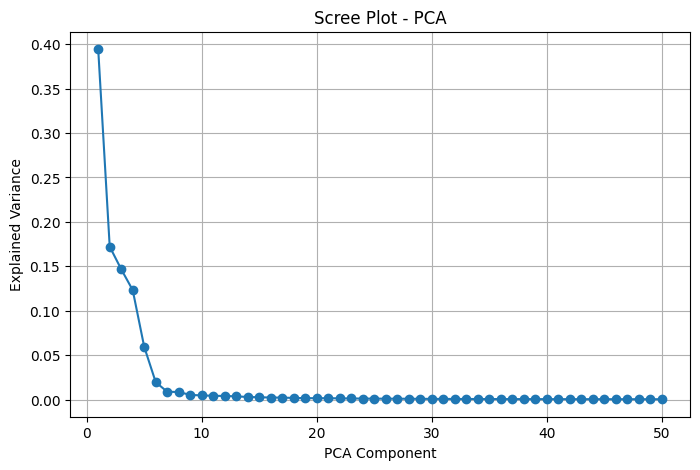

In [89]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.show()


We can see clearly here that the explained variance has pretty much zeroed out after 10, so lets try keeping just 10 components to zoom into the best elbow

In [90]:
k = 10

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

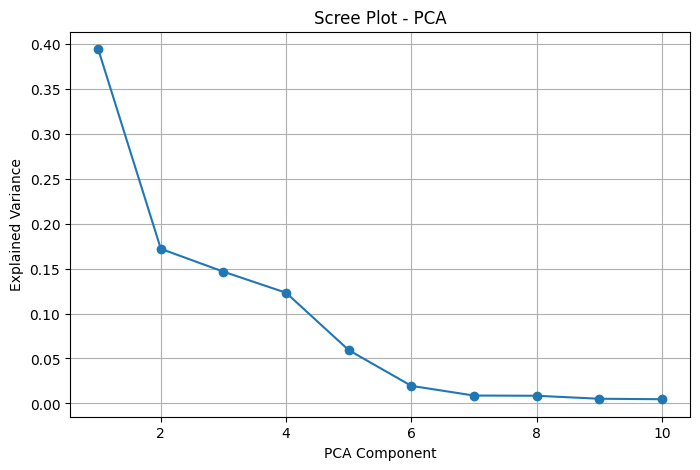

In [91]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.savefig('RF_PCA_Scree_Plot')
plt.show()

After getting a good look at the plot, it seems like 6 is the last relevant PCA component, and even that is pretty low. We will try 7 just to be safe, but everything after that we can pretty confidently attribute to noise.

In [96]:
k = 10

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

In [ ]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)

param_grid = {
    'n_estimators': np.arange(1, 1000, 100),
    'max_features': [None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
random_search.fit(X_train_split, y_train_split)

print('Best parameters:', random_search.best_params_)
print('Best CV score:', random_search.best_score_)

val_score = random_search.score(X_val, y_val)
print('Validation set score:', val_score)

Best parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': np.int64(601)}
Best CV score: -4.9267574355187405
Validation set score: -4.844197909601666


In [94]:
y_test_pred = random_search.predict(X_test_pca)

test_index = X_test_flat[["obs"]].reset_index(drop=True)

pred_df = pd.concat(
    [test_index, pd.DataFrame(y_test_pred, columns=["y_1", "y_2"])],
    axis=1
)

pred_df.head()

,obs,y_1,y_2
0,18,39.262355,104.675329
1,19,35.736567,100.805968
2,20,37.812735,98.055768
3,21,36.047126,96.673733
4,22,36.010259,95.782934


In [95]:
# pred_df.to_csv("rf_pca_submission_1.csv", index=False)